Latest version

# Capstone 2 : Exploratory Data Analysis

## Recall, at the end of the Data Wrangling notebook we left off with 
    datapath = '../data/processed'
    save_file(data15clean, 'clean15.csv', datapath)
    
## as our cleaned data.

The feature we will be focusing on will be the type of pitch thrown. For now I decided to focus on starting pitchers as they provide more data and are typically required to have a more diverse pitch repoitoire than relief pitchers who only pitch for an inning or 2. 

The data will be acquired from https://www.kaggle.com/pschale/mlb-pitch-data-20152018?select=pitches.csv
which was scraped from  http://gd2.mlb.com/components/game/mlb/.


*I could still consider going back to creating a model for a single player but make the pipeline or function such that the player can be changed easily before running. **

# Imports

In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from library.sb_utils import save_file

In [15]:
#missing values function
def missing(df):
    '''Takes dataframe as argument, 
    returns count and % of missing values for each column'''
    import pandas as pd
    miss = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis = 1)
    miss.columns = ['count','%']
    return miss.sort_values(by = ['count'], ascending = False)

In [16]:
filepath = '../data/processed/clean15.csv'

In [17]:
data = pd.read_csv(filepath)

We'll use a few standard pandas dataframe methods to review the properties of our cleaned data

In [18]:
data.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,...,type,pitch_type,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,S,FF,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,S,FF,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0
2,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,S,FF,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0
3,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,B,FF,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0
4,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,B,CU,0.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0


pd get_dummies() 1 hot encoding to create multiple columns from 1 (categorical)

2nd type is label encoding for ordinal features 
get the number of categories, assign value, put into dict, create a map

In [19]:
#double check that we dont have any missing values
missing(data)

,count,%
ab_id,0,0.0
batter_id,0,0.0
on_2b,0,0.0
on_1b,0,0.0
pitch_num,0,0.0
outs,0,0.0
s_count,0,0.0
b_count,0,0.0
b_score,0,0.0
pitch_type,0,0.0


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21602 entries, 0 to 21601
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ab_id       21602 non-null  int64  
 1   batter_id   21602 non-null  int64  
 2   event       21602 non-null  object 
 3   g_id        21602 non-null  int64  
 4   inning      21602 non-null  int64  
 5   o           21602 non-null  int64  
 6   p_score     21602 non-null  int64  
 7   p_throws    21602 non-null  object 
 8   pitcher_id  21602 non-null  int64  
 9   stand       21602 non-null  object 
 10  top         21602 non-null  bool   
 11  id          21602 non-null  int64  
 12  last_name   21602 non-null  object 
 13  date        21602 non-null  object 
 14  type        21602 non-null  object 
 15  pitch_type  21602 non-null  object 
 16  b_score     21602 non-null  float64
 17  b_count     21602 non-null  float64
 18  s_count     21602 non-null  float64
 19  outs        21602 non-nul

#data.describe()
Encoded:
Nominal or ordinal (ordered) feature (identify)
2 options, label encoding for ordinal 
1 

In [21]:
data.corr()

,ab_id,batter_id,g_id,inning,o,p_score,pitcher_id,top,id,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b
ab_id,1.000000,0.066781,0.999990,0.031528,0.025075,-0.038446,-0.080594,-0.029842,-0.080594,-0.011220,-0.004679,0.017584,0.016263,0.013609,-0.023364,0.004234,-0.001584
batter_id,0.066781,1.000000,0.066853,0.015528,-0.015304,0.030050,-0.032001,0.013836,-0.032001,-0.011592,0.013114,0.011350,-0.016523,0.011228,-0.017507,-0.011000,-0.001280
g_id,0.999990,0.066853,1.000000,0.031366,0.025007,-0.039017,-0.080589,-0.030112,-0.080589,-0.011665,-0.004671,0.017591,0.016162,0.013605,-0.023310,0.004133,-0.001563
inning,0.031528,0.015528,0.031366,1.000000,-0.024359,0.463773,-0.038845,-0.026315,-0.038845,0.247558,0.002325,-0.002908,-0.015481,0.000387,-0.016580,0.003676,-0.005271
o,0.025075,-0.015304,0.025007,-0.024359,1.000000,-0.002036,-0.016596,0.008393,-0.016596,0.029826,-0.028491,0.023074,0.870840,-0.011721,0.131614,0.124524,0.077002
p_score,-0.038446,0.030050,-0.039017,0.463773,-0.002036,1.000000,-0.022190,-0.120106,-0.022190,0.127076,0.004397,0.006752,0.005561,0.008727,-0.020935,0.023407,0.020093
pitcher_id,-0.080594,-0.032001,-0.080589,-0.038845,-0.016596,-0.022190,1.000000,-0.021117,1.000000,0.008959,-0.015018,0.021704,-0.010693,0.013850,0.007673,-0.000672,-0.012939
top,-0.029842,0.013836,-0.030112,-0.026315,0.008393,-0.120106,-0.021117,1.000000,-0.021117,-0.029726,0.000666,0.007605,0.009754,0.009253,0.001246,-0.014769,0.005076
id,-0.080594,-0.032001,-0.080589,-0.038845,-0.016596,-0.022190,1.000000,-0.021117,1.000000,0.008959,-0.015018,0.021704,-0.010693,0.013850,0.007673,-0.000672,-0.012939
b_score,-0.011220,-0.011592,-0.011665,0.247558,0.029826,0.127076,0.008959,-0.029726,0.008959,1.000000,0.016208,-0.025028,0.059144,-0.008264,0.050281,0.081191,0.074265


We wrapped up our data wrangling with the following display of histograms for each feature. While many do not tell us anything useful (for example, ab_id & g_id), we can gain a visual perspective of the values in other features (for example, s_count, b_count, outs).

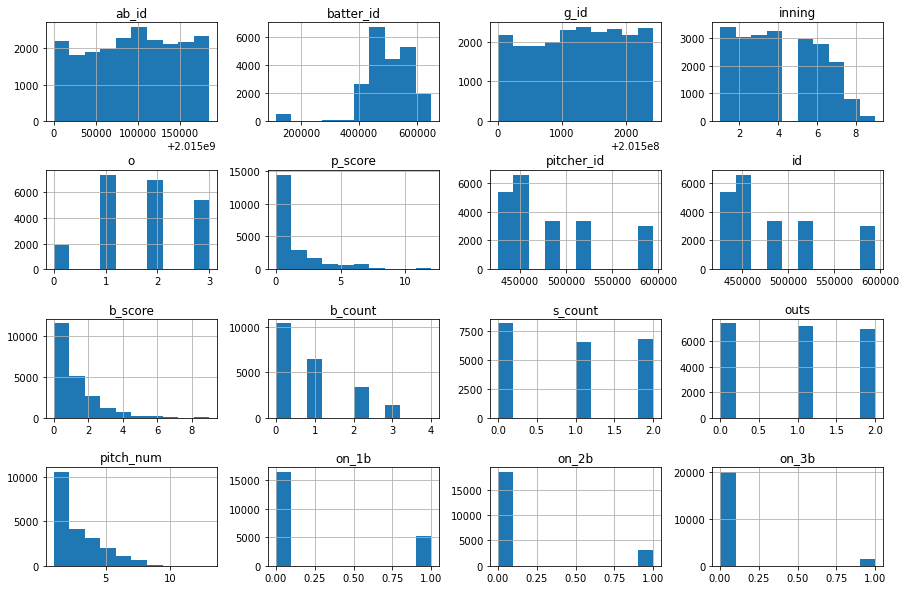

In [22]:
data.hist(figsize = (15,10))
plt.subplots_adjust(hspace = 0.5);

## Broad Strategies moving forward


We can try a couple different methods, one looking at correlating features for a given pitch type, and the other replacing the pitch type with integer values so we can include it in our correlation calculation. We can also try a chi-square test or multi-log regrerssion to compare categorical and continuous variables




Here is the distribution of all pitches thrown by the 7 pitchers in 2015

In [23]:
data.pitch_type.value_counts()

FF    9201
SL    3637
CH    2667
FT    2635
CU    2282
FC     814
SI     344
IN      13
EP       4
FA       2
PO       2
FS       1
Name: pitch_type, dtype: int64

Text(0.5, 1.0, 'Distribution of pitches  (7 starting pitchers in 2015)')

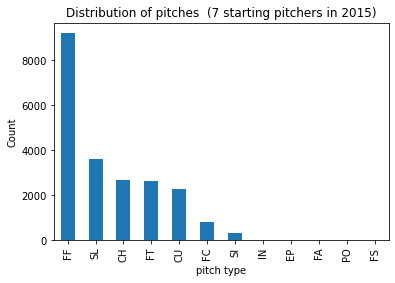

In [24]:
#pitch distribution independent of count
data.pitch_type.value_counts().plot(kind='bar')
plt.xlabel('pitch type')
plt.ylabel('Count')
plt.title('Distribution of pitches  (7 starting pitchers in 2015)')
#plt.plot()

To simplify the analysis, we can get rid of pitches thrown only a few times, such as the eephus

In [25]:
pitch_types = {'FF': 1, 'SL': 2, 'CU': 3, 'FT': 4, 'CH': 5, 'FC': 6, 'SI': 7}
data = data[data.pitch_type.isin(pitch_types.keys())]
data.pitch_type.value_counts()

FF    9201
SL    3637
CH    2667
FT    2635
CU    2282
FC     814
SI     344
Name: pitch_type, dtype: int64


The plots below demonstrate how the distribution of pitch types vary depending on the count. 

# Change data15 name

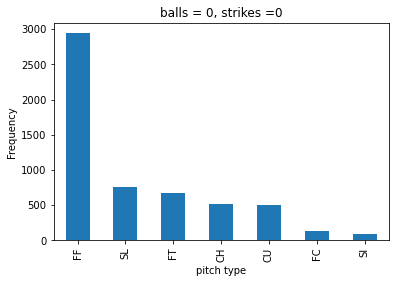

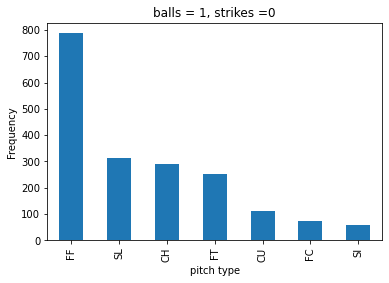

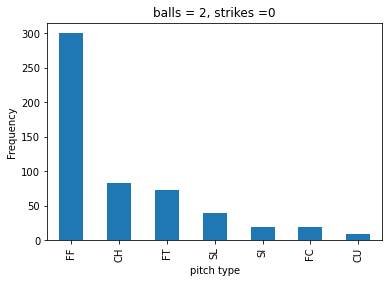

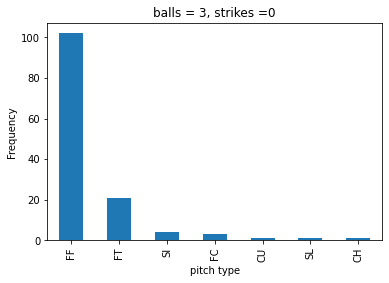

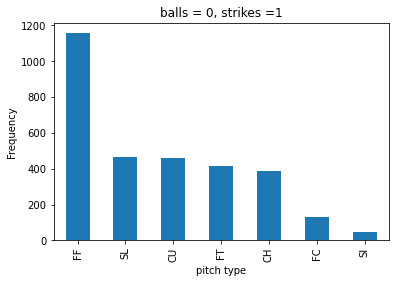

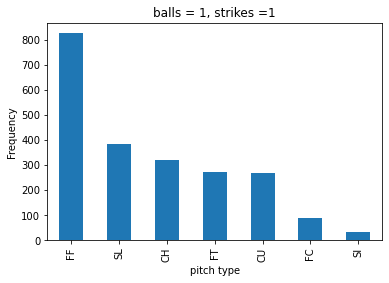

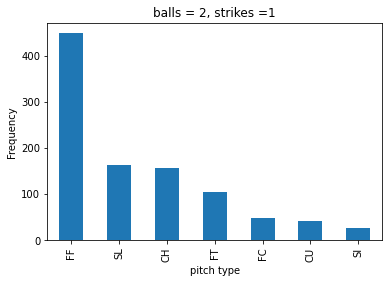

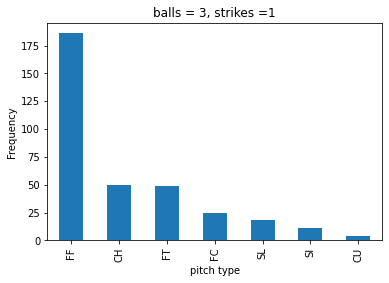

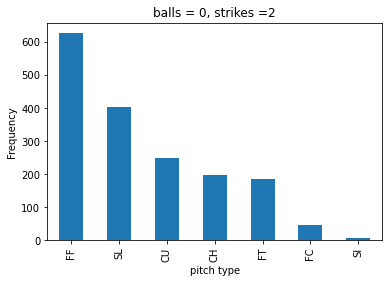

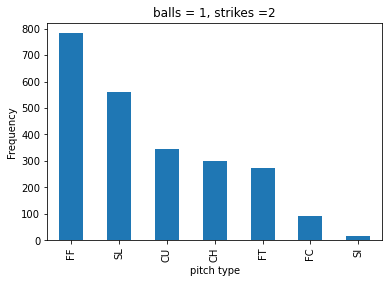

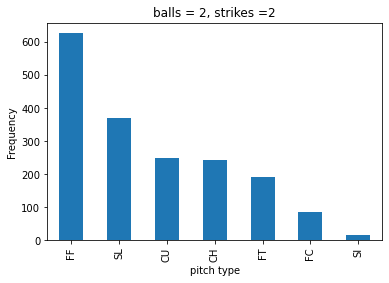

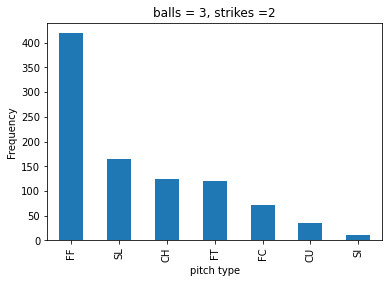

In [26]:
#plots that show the distribution of pitches depending on the balls and strikes 
for i in range(3):
    for j in range(4):
        plt.figure()
        data[np.logical_and(data.loc[:, 's_count'].astype(int) == i ,\
                                   data.loc[:, 'b_count'].astype(int) == j)]\
        .pitch_type.value_counts().plot(kind = 'bar')
        plt.xlabel('pitch type')
        plt.ylabel('Frequency')
        plt.title('balls = ' +str(j)+', strikes =' +str(i))
        plt.show()

If you are familiar with baseball, these distributions may not come as a surprise.

One can see that in counts favoring the pitcher (0 balls 2 strikes, 1 ball 2 strikes etc), it is more common to see pitchers throw a more diverse selection of pitches (sliders, curveballs etc). With counts favoring the hitter (2+ balls, 0 strikes etc), pitchers throw the fastball more often to avoid walking batters (throwing 4 balls which puts the hitter on first base) as it is easier to control.

<div style='padding: 15px; font-size: 125%; font-weight:bold; background-color: gray; color: white; margin-bottom: 20px'> 
Other immediate factors to consider that may influence the type of pitch being thrown include whether there are runners on base, and how many outs there are. 
</div>

For example, with the bases loaded (runners on first, second, and third), a pitcher may be less likely to throw breaking pitches which could end up outside of the strike zone, as a walk (4 balls) would result in a run being scored. Alternatively, if there are less than 2 outs and runners in scoring position (second or third base), a pitcher may be more inclined to throw breaking pitches to induce swings and misses. In this scenario, the negatives of allowing another runner on base (via a walk) could be outweighed by the positives of striking the batter out, as any hit would likely result in a run, and if a fast runner is on third, he will likely score on any kind of contact (even if it results in an out). I.e. a sacrifice fly or groundout which doesn't end the inning. 

<div style='padding: 15px; font-size: 125%; font-weight:bold; background-color: gray; color: white; margin-bottom: 20px'> 
We will now look at the distribution of pitches for each of the 8 runners-on-base scenarios. 
</div>

In [27]:
data[['on_1b','on_2b','on_3b']].head(20)

,on_1b,on_2b,on_3b
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
5,0.0,0.0,0.0
6,0.0,0.0,0.0
7,0.0,0.0,0.0
8,0.0,1.0,0.0
9,0.0,1.0,0.0


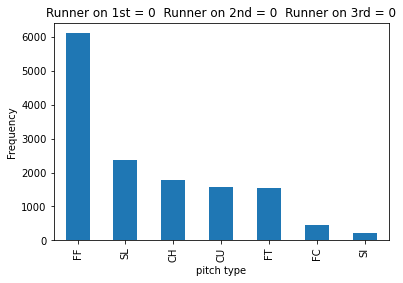

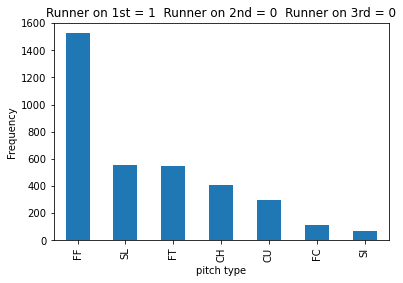

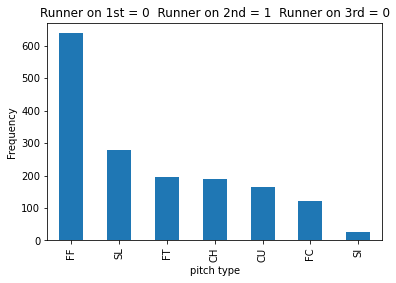

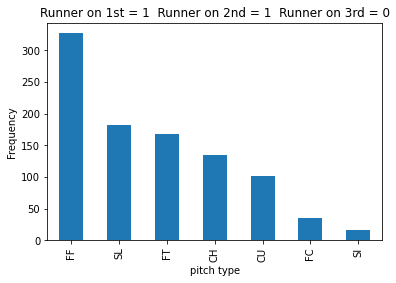

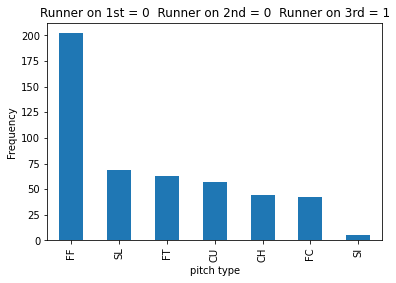

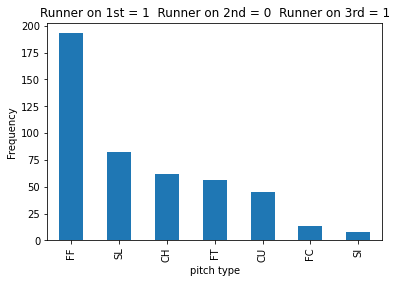

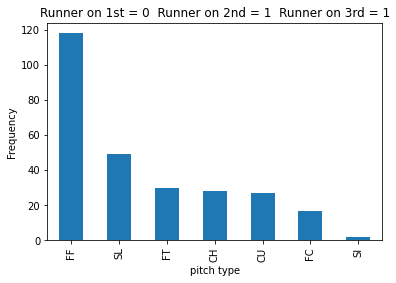

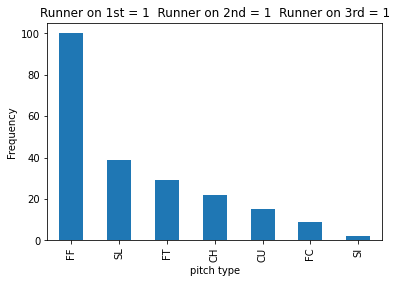

In [28]:
for k in range(2):
    for j in range(2):
        for i in range(2):
            plt.figure()
            data[np.logical_and(np.logical_and(data.loc[:, 'on_1b'].astype(int) == i ,\
                                       data.loc[:, 'on_2b'].astype(int) == j),\
                               data.loc[:, 'on_3b'].astype(int)==k)]\
            .pitch_type.value_counts().plot(kind = 'bar')
            plt.xlabel('pitch type')
            plt.ylabel('Frequency')
            plt.title('Runner on 1st = ' +str(i)+'  Runner on 2nd = ' +str(j)+'  Runner on 3rd = ' +str(k))
            plt.show()

In [29]:
#https://stackoverflow.com/questions/42818361/how-to-make-two-plots-side-by-side-using-python/42818547

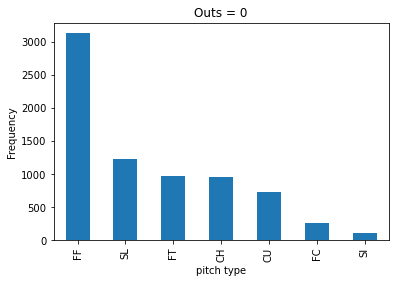

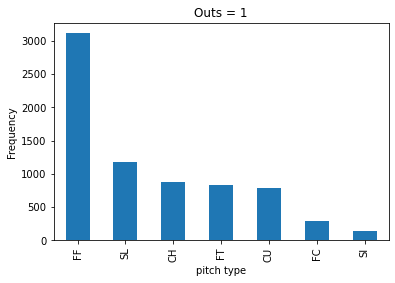

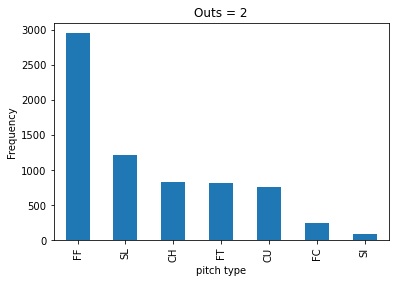

In [30]:
for i in range(3):
    plt.figure()
    data[data.loc[:, 'outs'].astype(int) == i].pitch_type.value_counts().plot(kind = 'bar')
    plt.xlabel('pitch type')
    plt.ylabel('Frequency')
    plt.title('Outs = ' +str(i))
    plt.show()

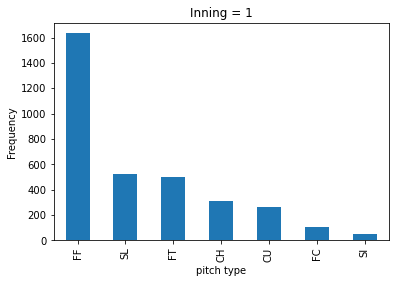

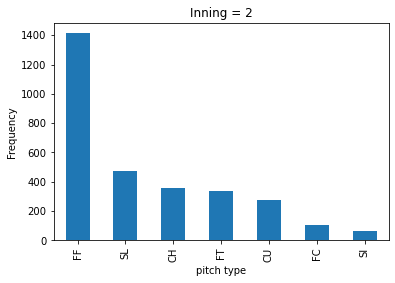

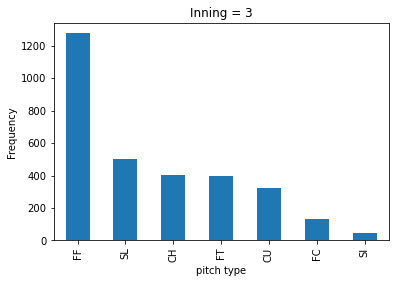

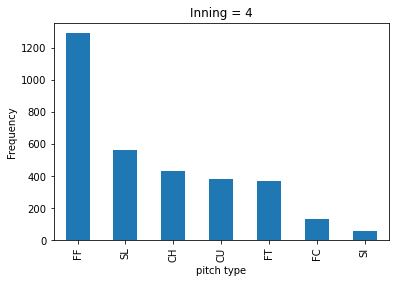

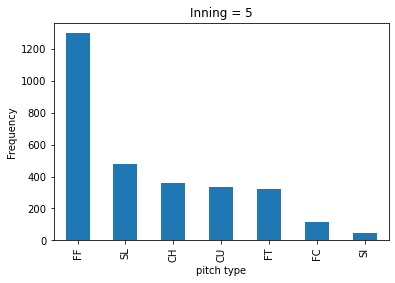

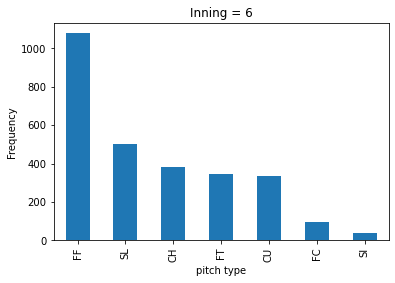

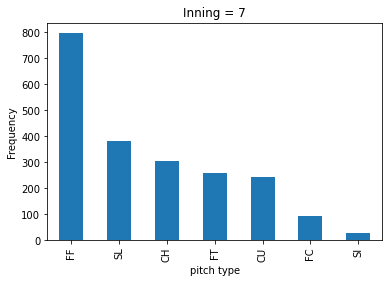

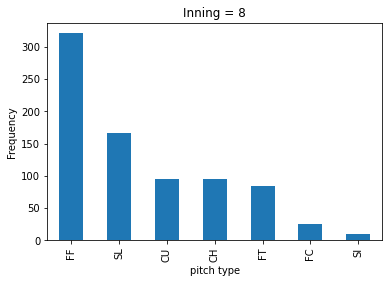

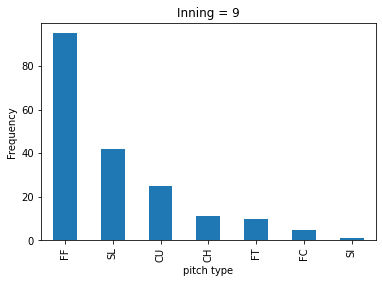

In [31]:
for i in range(1,10):
    plt.figure()
    data[data.loc[:, 'inning'].astype(int) == i].pitch_type.value_counts().plot(kind = 'bar')
    plt.xlabel('pitch type')
    plt.ylabel('Frequency')
    plt.title('Inning = ' +str(i))
    plt.show()

While the sample size becomes drastically smaller for the later innings, we can see some trends in that the pitches become more closely distributed. Conceptually, this makes sense because as a pitcher faces a lineup for the 3rd or even 4th time, they tend to diversify their repertoir depending on how the game has played out. 

Another (more even niche idea?) is that the way baseball is currently played and managed (with analytics driving many decisions), it is increasingly rare for a starting pitcher to pitch more than 7 innings. So, starters only pitch into the 8th and 9th innings if they are having a very dominant outing, perhaps even chasing a complete game shutout, no hitter, or perfect game. Having such an outing typically comes with the pitcher feeling confident with their entire arsenal of pitches.

### Pitch percentages by inning

In [32]:
percentages = pd.DataFrame()
for i in range(1,10):
    inning = []
    percentages[str(i)] = data[data.loc[:, 'inning'].astype(int) == i].pitch_type\
    .value_counts()/ data[data.loc[:, 'inning'].astype(int) == i].shape[0] *100

percentages

,1,2,3,4,5,6,7,8,9
FF,48.242245,46.633663,41.326861,39.901174,43.828204,38.763035,37.689394,40.225564,50.264550
SL,15.361891,15.643564,16.245955,17.418159,16.232668,18.122977,18.181818,20.927318,22.222222
FT,14.771049,11.221122,12.912621,11.488573,10.957051,12.441568,12.310606,10.526316,5.291005
CH,9.276219,11.815182,13.106796,13.403335,12.242137,13.736066,14.488636,11.904762,5.820106
CU,7.799114,9.141914,10.550162,11.890056,11.227596,12.010068,11.553030,11.904762,13.227513
FC,3.072378,3.498350,4.304207,4.138357,3.922895,3.451996,4.450758,3.258145,2.645503
SI,1.477105,2.046205,1.553398,1.760346,1.589449,1.474290,1.325758,1.253133,0.529101


In [33]:
transPerc = percentages.transpose(copy = True)
transPerc

,FF,SL,FT,CH,CU,FC,SI
1,48.242245,15.361891,14.771049,9.276219,7.799114,3.072378,1.477105
2,46.633663,15.643564,11.221122,11.815182,9.141914,3.498350,2.046205
3,41.326861,16.245955,12.912621,13.106796,10.550162,4.304207,1.553398
4,39.901174,17.418159,11.488573,13.403335,11.890056,4.138357,1.760346
5,43.828204,16.232668,10.957051,12.242137,11.227596,3.922895,1.589449
6,38.763035,18.122977,12.441568,13.736066,12.010068,3.451996,1.474290
7,37.689394,18.181818,12.310606,14.488636,11.553030,4.450758,1.325758
8,40.225564,20.927318,10.526316,11.904762,11.904762,3.258145,1.253133
9,50.264550,22.222222,5.291005,5.820106,13.227513,2.645503,0.529101


Text(0.5, 1.0, 'Changes in pitch frequency by inning')

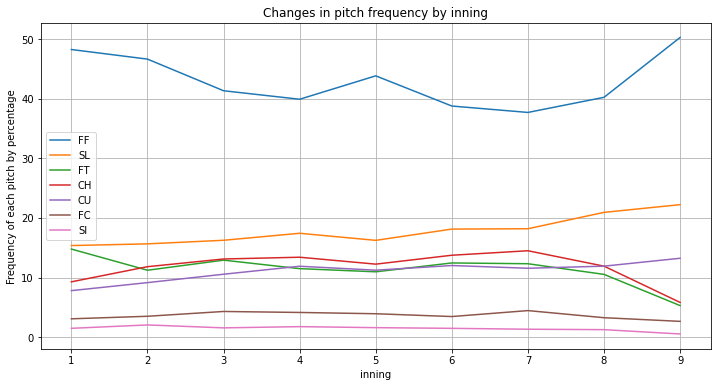

In [34]:
transPerc.plot(figsize=(12,6), grid=True)
plt.xlabel('inning')
plt.ylabel('Frequency of each pitch by percentage')
plt.title('Changes in pitch frequency by inning')

<div style='padding: 15px; font-size: 125%; font-weight:bold; background-color: gray; color: white; margin-bottom: 20px'> 
Pitch tendancies vs left and right handed batters
        
</div>
Another major factor in pitcher batter matchups comes from the handedness of the 2 players. The general consensus is that pitchers fare better against batters of the same dominant hand (i.e. right handed pitcher vs right handed batter). When a batter stands opposite the pitchers throwing arm (i.e right handed pitcher vs left handed batter), in general, the batter is able to see the ball release from the pitchers hand at a clearer angle. This is exagerated with pitchers that are tall/lanky or have unorthodox deliveries, as the ball is essentially seen to be starting from behind the batter's head. 

One pitcher notorious for dominating same sided hitters was the lefty Randy Johnson, who stood 6 ft 10 inches and threw fastballs at over 100 MPH. In the 1997 all star game, left handed slugger Larry Walker (a left hander) put his helmet on backwards and hit as a right hander against Johnson. It was mostly done for comedy, but is still a fun example of the differences that stance can make in a matchup. 

https://www.youtube.com/watch?v=sqcfUSDT10s

In [35]:
#stand = L, R (batter stance)

# P_throws is for pitcher
data.p_throws.value_counts()

R    11696
L     9884
Name: p_throws, dtype: int64

L L


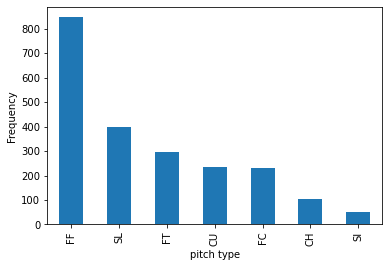

L R


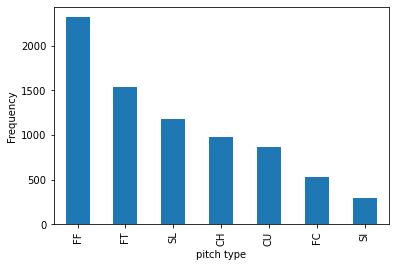

R L


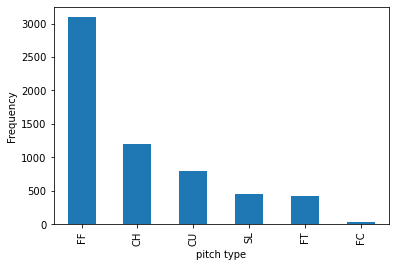

R R


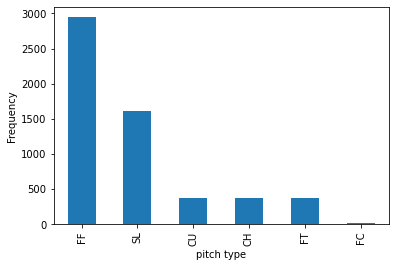

In [36]:
hand = ['L','R']
for h in hand:
    for b in hand:
        plt.figure()
        data[np.logical_and(data.loc[:, 'p_throws'] ==  h,\
                                       data.loc[:, 'stand'] == b)].pitch_type.value_counts().plot(kind = 'bar')
        plt.xlabel('pitch type')
        plt.ylabel('Frequency')
        
        print(h,b)
        plt.show()

We wont spend time now analyzing these splits, but will keep in mind that the batter's stance as well as pitchers throwing hand could be important predictive features. 

I'm making duplicates of the data at this point in case I want to use a different method of encoding in the future. 

In [37]:
data_counts = data
data_counts['b_s'] = list(zip(data.b_count.astype(int), data.s_count.astype(int)))
data_counts

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,...,pitch_type,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,b_s
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"(0, 0)"
1,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,"(0, 1)"
2,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,"(0, 2)"
3,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,FF,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,"(0, 2)"
4,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,CU,0.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0,"(1, 2)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21597,2015184080,150029,Strikeout,201502429,4,2,0,R,594798,R,...,FF,0.0,1.0,2.0,1.0,4.0,0.0,0.0,0.0,"(1, 2)"
21598,2015184080,150029,Strikeout,201502429,4,2,0,R,594798,R,...,CH,0.0,2.0,2.0,1.0,5.0,0.0,0.0,0.0,"(2, 2)"
21599,2015184081,519208,Groundout,201502429,4,3,0,R,594798,L,...,CH,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,"(0, 0)"
21600,2015184081,519208,Groundout,201502429,4,3,0,R,594798,L,...,CH,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,"(0, 1)"


In [38]:
data.pitch_type.value_counts()

FF    9201
SL    3637
CH    2667
FT    2635
CU    2282
FC     814
SI     344
Name: pitch_type, dtype: int64

In [39]:
pitch_types = {'FF': 1, 'SL': 2, 'CU': 3, 'FT': 4, 'CH': 5, 'FC': 6, 'SI': 7}
data = data[data.pitch_type.isin(pitch_types.keys())]
data.pitch_type.value_counts()

FF    9201
SL    3637
CH    2667
FT    2635
CU    2282
FC     814
SI     344
Name: pitch_type, dtype: int64

<div style='padding: 15px; font-size: 125%; font-weight:bold; background-color: gray; color: white; margin-bottom: 20px'> 
Instead of using the following dictionary mapping, we will likely encode the target variable (pitch_type) using pd.get_dummies.
        
</div>
This isn't something we need to decide now, as we will probably become more informed on the best way to format the target feature in the feature engineering and preprocessing stages. 

So, for now, we can keep this pitch types dict as it may be useful in the future


<div style='padding: 15px; font-size: 125%; font-weight:bold; background-color: gray; color: white; margin-bottom: 20px'> 
I will go ahead and make new variables X and y, where y will represent the encoded pitch_types, and X the remaining columns

    
</div>
Encoding the variable now will allow us to view it in a correlation matrix


In [40]:
df_encoded = pd.get_dummies(data, columns = ['pitch_type'])

In [41]:
X = data

In [42]:
X = data.drop(columns = ["pitch_type"])
y = pd.get_dummies(data.pitch_type)

In [43]:
X.head()

,ab_id,batter_id,event,g_id,inning,o,p_score,p_throws,pitcher_id,stand,...,type,b_score,b_count,s_count,outs,pitch_num,on_1b,on_2b,on_3b,b_s
0,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,S,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"(0, 0)"
1,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,S,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,"(0, 1)"
2,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,S,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,"(0, 2)"
3,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,B,0.0,0.0,2.0,0.0,4.0,0.0,0.0,0.0,"(0, 2)"
4,2015000001,572761,Groundout,201500001,1,1,0,L,452657,L,...,B,0.0,1.0,2.0,0.0,5.0,0.0,0.0,0.0,"(1, 2)"


In [44]:
y.head()

,CH,CU,FC,FF,FT,SI,SL
0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0


Here is the correlation matrix

In [45]:
df_encoded.corr()

,ab_id,batter_id,g_id,inning,o,p_score,pitcher_id,top,id,b_score,...,on_1b,on_2b,on_3b,pitch_type_CH,pitch_type_CU,pitch_type_FC,pitch_type_FF,pitch_type_FT,pitch_type_SI,pitch_type_SL
ab_id,1.000000,0.066903,0.999990,0.031160,0.025252,-0.038286,-0.079386,-0.030436,-0.079386,-0.010309,...,-0.023544,0.005777,-0.001844,-0.028320,0.028064,-0.013189,0.010426,-0.020969,-0.022307,0.020585
batter_id,0.066903,1.000000,0.066976,0.015350,-0.015345,0.029796,-0.032086,0.014186,-0.032086,-0.010759,...,-0.017788,-0.009712,-0.001003,-0.003693,0.018759,0.001808,0.004614,-0.008635,-0.016909,-0.005969
g_id,0.999990,0.066976,1.000000,0.030997,0.025185,-0.038856,-0.079378,-0.030707,-0.079378,-0.010753,...,-0.023490,0.005678,-0.001826,-0.028286,0.028066,-0.013256,0.010348,-0.020838,-0.022317,0.020580
inning,0.031160,0.015350,0.030997,1.000000,-0.024354,0.463933,-0.038163,-0.026499,-0.038163,0.248316,...,-0.016526,0.004429,-0.005498,0.030314,0.042675,0.008500,-0.056326,-0.024044,-0.010338,0.032868
o,0.025252,-0.015345,0.025185,-0.024354,1.000000,-0.002336,-0.017009,0.008482,-0.017009,0.029612,...,0.131952,0.124471,0.077562,-0.010893,0.019553,-0.003671,0.002955,-0.027432,-0.003412,0.016613
p_score,-0.038286,0.029796,-0.038856,0.463933,-0.002336,1.000000,-0.021980,-0.119982,-0.021980,0.127250,...,-0.021132,0.023750,0.020565,0.021812,0.008019,-0.005019,-0.020867,-0.008077,-0.018058,0.017464
pitcher_id,-0.079386,-0.032086,-0.079378,-0.038163,-0.017009,-0.021980,1.000000,-0.020313,1.000000,0.007893,...,0.008286,-0.002459,-0.012370,0.049914,-0.057852,-0.102059,-0.135799,0.270983,-0.065709,0.019967
top,-0.030436,0.014186,-0.030707,-0.026499,0.008482,-0.119982,-0.020313,1.000000,-0.020313,-0.029223,...,0.000981,-0.013916,0.005212,-0.005194,0.001391,0.037876,0.004494,-0.008658,0.019709,-0.020812
id,-0.079386,-0.032086,-0.079378,-0.038163,-0.017009,-0.021980,1.000000,-0.020313,1.000000,0.007893,...,0.008286,-0.002459,-0.012370,0.049914,-0.057852,-0.102059,-0.135799,0.270983,-0.065709,0.019967
b_score,-0.010309,-0.010759,-0.010753,0.248316,0.029612,0.127250,0.007893,-0.029223,0.007893,1.000000,...,0.050906,0.079692,0.074264,0.042938,0.010509,0.031160,-0.069321,0.019268,0.026311,0.003685


Keep in mind that the bottom right corner of the correlation matrix/heatmap shouldn't be a point of focus, as the pitches are mutually exclusive and will naturally be negatively correlated with each other

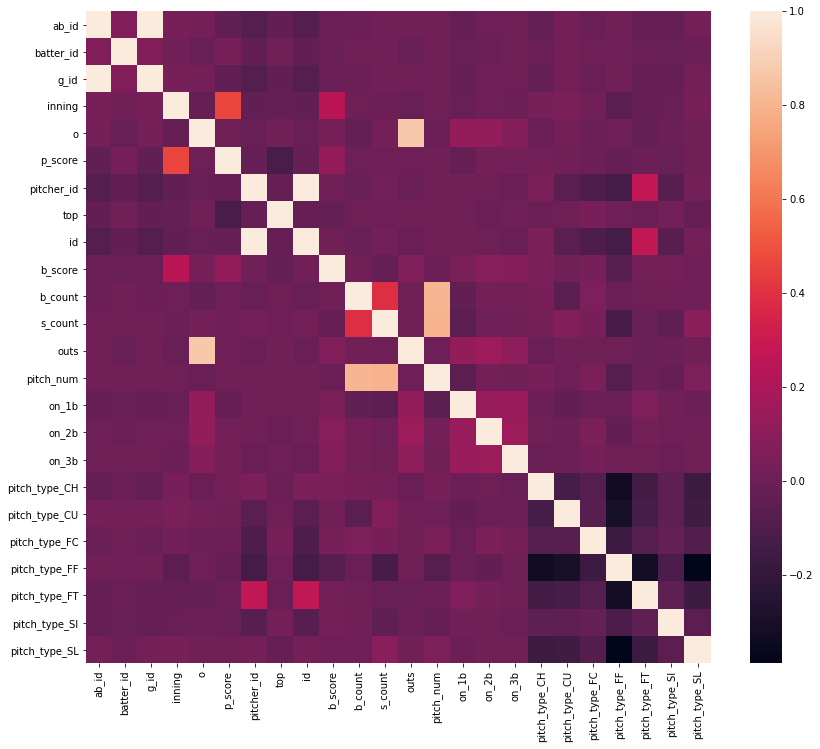

In [46]:
plt.subplots(figsize=(14,12))
sns.heatmap(df_encoded.corr());

I'll end things here, as we are now delving into the more preprocessing/feature engineering territory.